# implement matrix factorization for movielens dataset

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import csr_matrix
np.seterr(all='raise')
import warnings

# load data from movielens

In [20]:
df = pd.DataFrame(np.zeros((943,1682) , dtype=np.float64))

In [3]:
print(df.shape)

(943, 1682)


In [4]:
with open("movielens_100K.data" , "r") as data:
    for line in data:
        line_l = line.split()
        df.iloc[int(line_l[0])-1 , int(line_l[1])-1] = int(line_l[2])

In [5]:
rating_data = df.as_matrix()

In [76]:
print(rating_data)

[[ 5.  3.  4. ...,  0.  0.  0.]
 [ 4.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 5.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  5.  0. ...,  0.  0.  0.]]


# matrix factorization

In [89]:
class MF():
    '''
    number of user = 943
    number of item = 1682
    k = number of latent dim
    U = (943 * k) : user latent matrix
    V = (1682 * k) : item latent matrix
    R = (943 * 1682) : user item rating matrix
    alpha = 0.2
    '''
    def __init__(self , k , rating , iteration , alpha , beta):
        
        self._num_user , self._num_item = rating.shape
        
        self._R = rating
        self._iteration = iteration
        
        self._alpha = alpha
        self._beta = beta
        
        #初始化 user latent matrix and item latent matrix
        self._U = np.random.normal(loc = 0.0 , scale=1/k , size = (self._num_user , k) )
        self._U.astype(np.float64)
        self._V = np.random.normal(loc = 0.0 , scale=1/k , size = (self._num_item , k) )
        self._V.astype(np.float64)
        #初始化 user bias and item bias
        self._user_bias = np.zeros(self._num_user ,dtype = "float64")
        self._item_bias = np.zeros(self._num_item ,dtype = "float64")
        self._bias = np.mean( self._R[np.where(self._R != 0 )]  ,dtype = "float64")
        
        
    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self._R.nonzero()
        predicted = self.result()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self._R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)
        
    def train(self):
        #create training data
        self._training_data = [
            (i,j)
            for i in range(self._num_user)
            for j in range(self._num_item)
            if self._R[i,j]!=0 
        ]
        
        training_process = []
        
        for iteration in range(self._iteration):
            np.random.shuffle(self._training_data)
            self.sgd()
            
            mse = self.mse()
            training_process.append((iteration, mse))
            if (iteration+1) % 10 == 0:
                print("Iteration: %d ; error = %.4f" % (iteration+1, mse))
        
        return training_process
    
    
    def get_prediction(self , i , j):
        
        prediction = self._bias + self._user_bias[i] + self._item_bias[j] + np.dot( self._U[i,:] , self._V[j,:].T )
        return prediction
    
    def sgd(self):
        for i,j in self._training_data:
            e = ( self._R[i,j] - self.get_prediction(i,j) )

            #update bias
            self._user_bias[i] += self._alpha * (e - self._beta * self._user_bias[i])
            self._item_bias[j] += self._alpha * (e - self._beta * self._item_bias[j])
            
            
            try:
                # update user item latent vector
                self._U[i,:] += self._alpha * (e * self._V[j,:] - self._beta * self._U[i,:])           
                self._V[j,:] += self._alpha * (e * self._U[i,:] - self._beta * self._V[j,:])
            except:
                break


            

    def result(self):
        return self._bias + self._user_bias[:,np.newaxis] + self._item_bias[np.newaxis:,] + np.dot(self._U , self._V.T )

In [90]:
mf = MF(100 , rating_data ,100 , 0.05 , 0.01)

In [93]:
training_process = mf.train()

Iteration: 10 ; error = 30.8690
Iteration: 20 ; error = 30.7653
Iteration: 30 ; error = 30.5618
Iteration: 40 ; error = 30.3245
Iteration: 50 ; error = 30.2290
Iteration: 60 ; error = 30.2346
Iteration: 70 ; error = 30.0238
Iteration: 80 ; error = 29.9930
Iteration: 90 ; error = 29.9016
Iteration: 100 ; error = 29.8097


In [81]:
print(mf.result())

[[ 4.85748405  2.85270281  4.08949215 ...,  3.29216279  3.61209569
   3.39032322]
 [ 3.98942004  2.33639396  3.93856017 ...,  3.54114366  3.71320958
   3.59969814]
 [ 2.83154301  2.04566983  2.8926328  ...,  2.6673911   3.03279344
   2.90349465]
 ..., 
 [ 4.98732475  3.74288951  3.23868383 ...,  3.5191485   3.88554047
   3.71764527]
 [ 4.21385726  3.42632259  4.19744459 ...,  3.69354097  3.96257622
   3.84899867]
 [ 4.01884865  4.85938589  1.52496295 ...,  3.22432531  3.48439168
   3.34806971]]


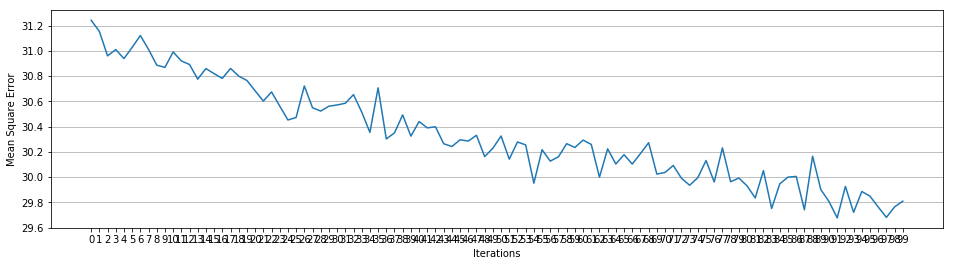

In [94]:
x = [x for x, y in training_process]
y = [y for x, y in training_process]
plt.figure(figsize=((16,4)))
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.grid(axis="y")